# 2️⃣ Preparació de les dades per al model DWTFormer

Aquest notebook mostra com es carreguen, processen i preparen les dades del projecte. Inclou visualitzacions, normalització, divisió de conjunts i aplicació preliminar de la DWT.


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pywt
import numpy as np
import pywt
import torch
from medmnist import INFO
from torch.utils.data import DataLoader


Càrrega del dataset

In [7]:
# Paràmetres
dataset_name = 'pathmnist'  # Canviar a 'chestmnist' o 'organmnist_axial' si cal

# Metadata
info = INFO[dataset_name]
DataClass = eval(info['python_class'])  # o usar PathMNIST directament

# Transformacions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Dades
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)


Visualització d’imatges

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52156866..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823529..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

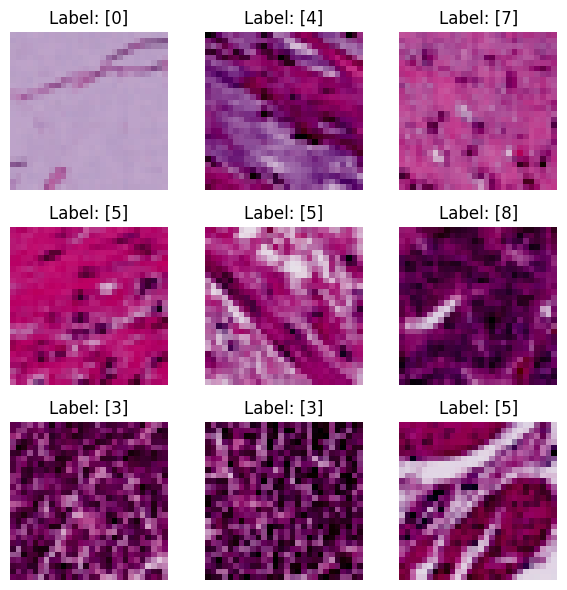

In [8]:
# Visualitzar 9 imatges del set de train
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(9):
    img, label = train_dataset[i]
    axs[i // 3, i % 3].imshow(img.permute(1, 2, 0))
    axs[i // 3, i % 3].set_title(f"Label: {label}")
    axs[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


Aplicació de la DWT a una imatge

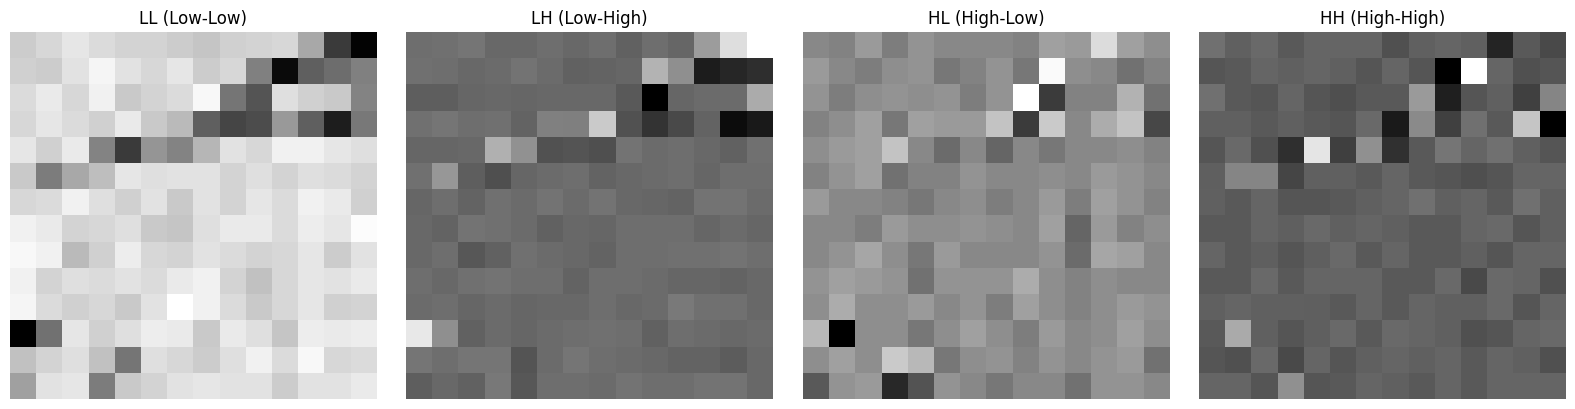

In [10]:
# Seleccionar una imagen y convertirla a numpy
img, label = train_dataset[0]

# Si es RGB (3 canales), usamos solo el canal 0 (puedes probar otros si quieres)
if img.shape[0] == 3:
    img_np = img[0].numpy()  # Seleccionamos el canal R
else:
    img_np = img.squeeze().numpy()

# Aplicar DWT
coeffs2 = pywt.dwt2(img_np, 'haar')
LL, (LH, HL, HH) = coeffs2

# Visualización
titles = ['LL (Low-Low)', 'LH (Low-High)', 'HL (High-Low)', 'HH (High-High)']
components = [LL, LH, HL, HH]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(components[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:

def apply_dwt_batch(batch, wavelet='haar'):
    """
    Aplica la DWT a cada imagen de un lote.

    Parameters:
        batch (Tensor): Tensor de forma (B, C, H, W)
        wavelet (str): Tipo de wavelet a aplicar (default: 'haar')

    Returns:
        Tensor: Batch transformado, concatenando LL, LH, HL, HH (forma: B, 4, H/2, W/2)
    """
    transformed_images = []

    for img in batch:
        # Si la imagen tiene múltiples canales, usamos solo el primero
        if img.shape[0] == 3:
            img = img[0]  # Selecciona canal rojo
        else:
            img = img.squeeze()

        # Convertir a numpy
        img_np = img.numpy()

        # Aplicar DWT
        LL, (LH, HL, HH) = pywt.dwt2(img_np, wavelet)

        # Apilar canales y convertir a tensor
        dwt_tensor = torch.tensor([LL, LH, HL, HH], dtype=torch.float32)
        transformed_images.append(dwt_tensor)

    # Combinar en un solo batch (B, 4, H/2, W/2)
    return torch.stack(transformed_images)


In [ ]:

# Crear DataLoader con lotes pequeños
loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Obtener un lote
images, labels = next(iter(loader))  # (B, C, H, W)

# Aplicar DWT
dwt_batch = apply_dwt_batch(images)

print("Shape original:", images.shape)
print("Shape DWT:", dwt_batch.shape)


Shape original: torch.Size([4, 3, 28, 28])
Shape DWT: torch.Size([4, 4, 14, 14])


C:\Users\galla\AppData\Local\Temp\ipykernel_19460\1545648454.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  dwt_tensor = torch.tensor([LL, LH, HL, HH], dtype=torch.float32)


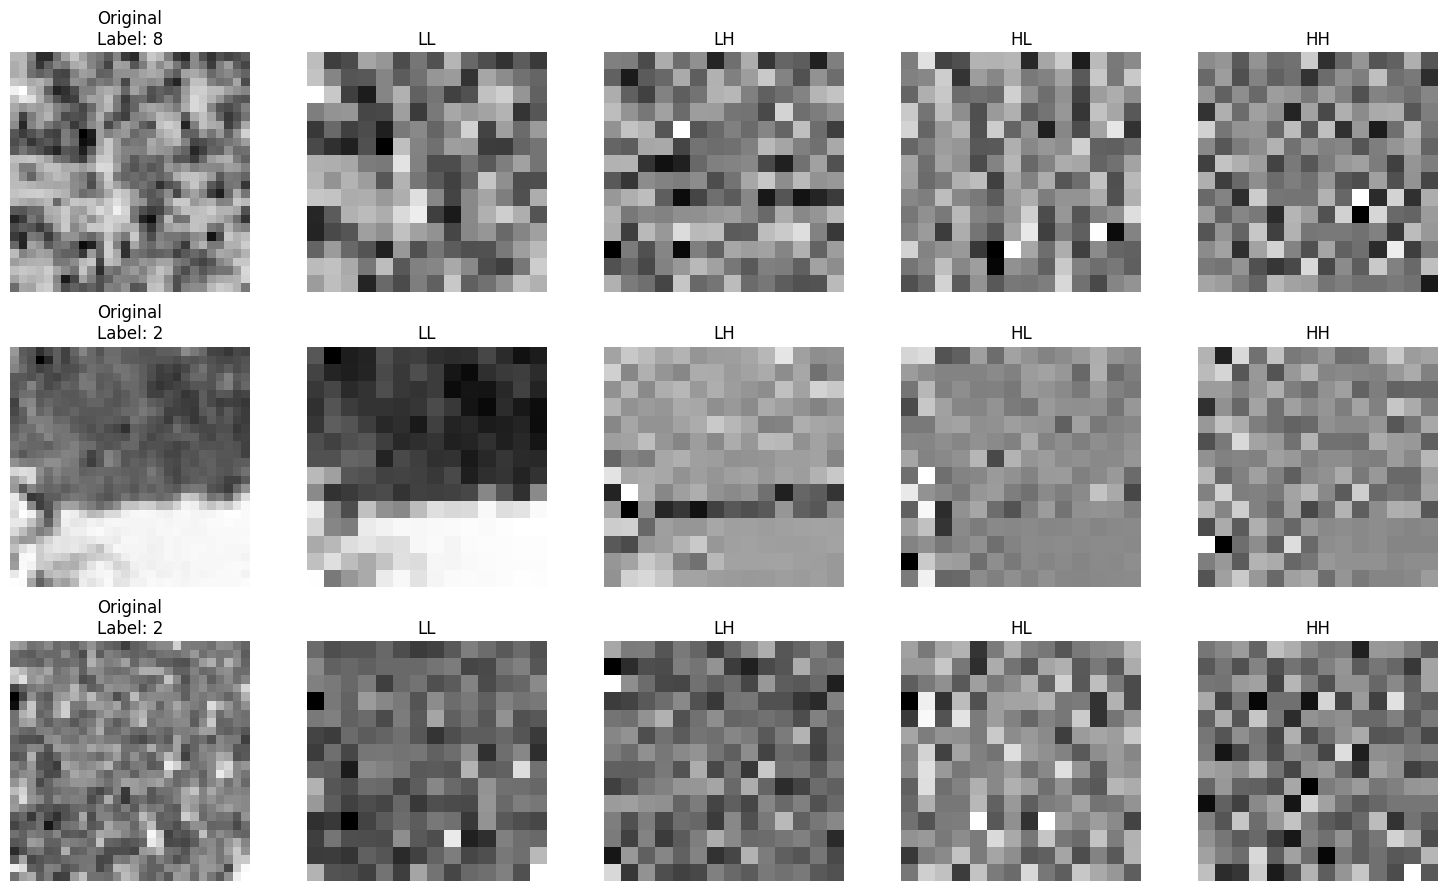

In [14]:
# ⚙️ Asegúrate de tener la función apply_dwt_batch cargada
def apply_dwt_batch(batch, wavelet='haar'):
    transformed_images = []

    for img in batch:
        # Seleccionar canal 0 si es RGB
        if img.shape[0] == 3:
            img = img[0]
        else:
            img = img.squeeze()

        img_np = img.numpy()
        LL, (LH, HL, HH) = pywt.dwt2(img_np, wavelet)
        dwt_tensor = torch.tensor([LL, LH, HL, HH], dtype=torch.float32)
        transformed_images.append(dwt_tensor)

    return torch.stack(transformed_images)


# 🔄 Obtener un lote del DataLoader
from torch.utils.data import DataLoader

loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
images, labels = next(iter(loader))
dwt_images = apply_dwt_batch(images)

# 🖼️ Visualizar original vs DWT
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
dwt_titles = ["LL", "LH", "HL", "HH"]

for i in range(3):
    # Imagen original
    img = images[i]
    axs[i, 0].imshow(img[0].numpy(), cmap='gray')  # canal 0
    axs[i, 0].set_title(f"Original\nLabel: {labels[i].item()}")
    axs[i, 0].axis('off')

    # Subbandas DWT
    for j in range(4):
        axs[i, j + 1].imshow(dwt_images[i][j].numpy(), cmap='gray')
        axs[i, j + 1].set_title(dwt_titles[j])
        axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


Cada imatge ha estat transformada amb la Discrete Wavelet Transform (DWT), descomponent-la en quatre subbandes. Aquesta representació multiescala proporciona informació estructural i de detall que pot ser clau per a la detecció de patrons associats a lesions esportives.

Aquesta transformació no només redueix la dimensió espacial (de 28x28 a 14x14), sinó que també facilita que el model aprengui característiques rellevants sense soroll redundant.